## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import os
import sys
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder

path_program = ls_level(os.getcwd(), 3)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/


In [2]:
folder_figs = path_program + "data/cup1d/likelihood/max_like_mock/"

emulator_label = "mpg_gp"
# emulator_label = "mpg_nn"
# emulator_label = "nyx_nn"

# data_label = "QMLE_Ohio"
data_label = "Chabanier2019"

# specify if you want to add high-resolution P1D (not working for nyx emulator)
# add_hires = True
add_hires = False

sim_igm = emulator_label[:3]

if add_hires:
    emu_kmax_Mpc = 8
    emu_ndeg = 7
    flag_fig = data_label + "_" + emulator_label + "_hr"
else:
    extra_data = None
    emu_kmax_Mpc = 4
    emu_ndeg = 5
    flag_fig = data_label + "_" + emulator_label + "_lr"

plot = True

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
if emulator_label == "mpg_gp":
    emulator = gp_emulator.GPEmulator(
        training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg
    )
    zmin = 2.0
elif (emulator_label == "mpg_nn") & (add_hires == True):
    emulator = nn_emulator.NNEmulator(
        training_set="Cabayol23", emulator_label="Cabayol23_extended"
    )
    zmin = 2.0
elif (emulator_label == "mpg_nn") & (add_hires == False):
    emulator = nn_emulator.NNEmulator(
        training_set="Cabayol23", emulator_label="Cabayol23"
    )
    zmin = 2.0
elif emulator_label == "nyx_nn":
    assert not add_hires, "Nyx emulator not trained beyond k=4 1/Mpc"
    emulator = nn_emulator.NNEmulator(
        training_set="Nyx23", emulator_label="Nyx_v0"
    )
    zmin = 2.2
else:
    raise ValueError("wrong emulator_label", emulator_label)

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points


 /home/jchaves/miniconda3/envs/py11/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.70 seconds


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data = mock_data.Mock_P1D(
    emulator=emulator, data_label=data_label, sim_igm=sim_igm, zmin=zmin,
)

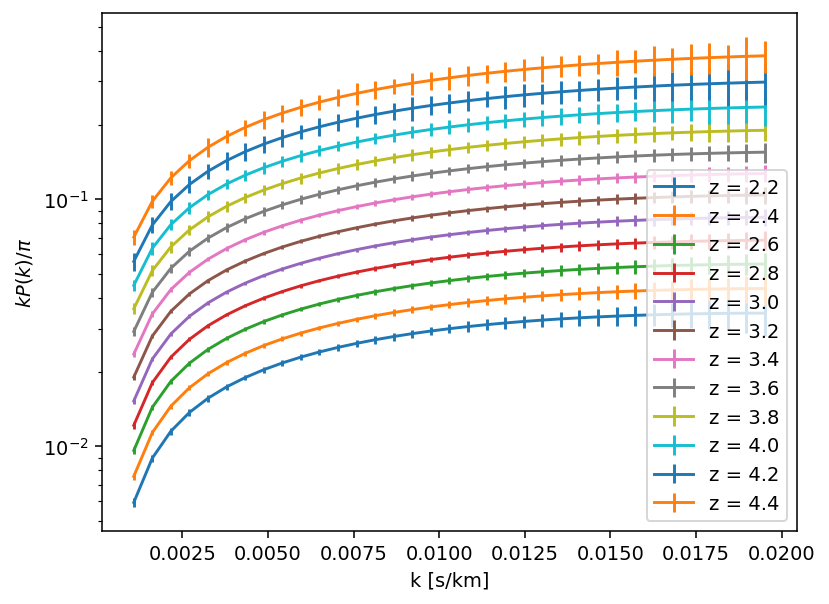

In [5]:
if plot:
    data.plot_p1d()

In [6]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data = mock_data.Mock_P1D(
        emulator=emulator, data_label="Karacayli2022"
    )
else:
    extra_data = None

### Set free parameters and theory

In [7]:
# stick to primordial power-law parameters here
free_param_names = ["As", "ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm = 2
for i in range(n_igm):
    for par in ["tau", "sigT_kms", "gamma", "kF"]:
        free_param_names.append("ln_{}_{}".format(par, i))

In [9]:
theory = lya_theory.Theory(
    zs=data.z,
    emulator=emulator,
    free_param_names=free_param_names,
)

In [10]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 7.4e-10 , 4.11e-09
ns = 0.965 , 0.68 , 1.32
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_gamma_1 = 0.0 , -1.6 , 1.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_kF_1 = 0.0 , -2.0 , 2.0


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [11]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms = None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor = 0
like = likelihood.Likelihood(
    data=data,
    theory=theory,
    free_param_names=free_param_names,
    prior_Gauss_rms=prior_Gauss_rms,
    emu_cov_factor=emu_cov_factor,
    extra_p1d_data=extra_data,
)

As = 2.4250000000000002e-09 , 7.4e-10 , 4.11e-09
ns = 1.0 , 0.68 , 1.32
ln_tau_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_0 = 0.0 , -2.0 , 2.0
ln_gamma_0 = 0.0 , -0.6 , 0.6
ln_kF_0 = 0.0 , -0.8 , 0.8
ln_tau_1 = 0.0 , -1.6 , 1.6
ln_sigT_kms_1 = 0.0 , -5.0 , 5.0
ln_gamma_1 = 0.0 , -1.6 , 1.6
ln_kF_1 = 0.0 , -2.0 , 2.0
chi2 = 1405.4880415233022


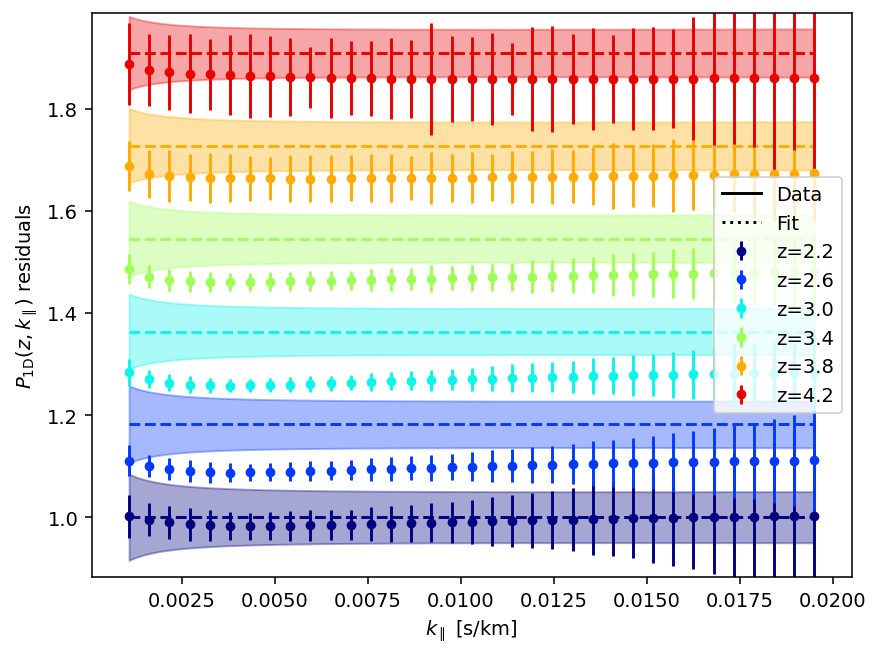

In [12]:
# check starting point for free parameters (should be equal to truth)
test_values = len(free_param_names) * [0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print("chi2 =", like.get_chi2(values=test_values))
if plot:
    like.plot_p1d(values=test_values, residuals=True, plot_every_iz=2)

In [13]:
if plot:
    if extra_data:
        like.extra_p1d_like.plot_p1d(residuals=True, plot_every_iz=2)

### Run iminuit minimizer

In [14]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma = 0.00002
ini_values = (
    2 * ini_sigma * np.random.random(len(like.free_params)) + 0.5 - ini_sigma
)
print("ini values", ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.49998166 0.50000033 0.49998303 0.49999739 0.49998361 0.50001838
 0.49998719 0.49998976 0.49998398 0.49999949]
As = 2.424938192895639e-09 , 7.4e-10 , 4.11e-09
ns = 1.0000002084652027 , 0.68 , 1.32
ln_tau_0 = -1.3577505418083113e-05 , -0.4 , 0.4
ln_sigT_kms_0 = -1.0427595651396615e-05 , -2.0 , 2.0
ln_gamma_0 = -1.9672625210298555e-05 , -0.6 , 0.6
ln_kF_0 = 2.94157880045276e-05 , -0.8 , 0.8
ln_tau_1 = -4.100473736201593e-05 , -1.6 , 1.6
ln_sigT_kms_1 = -0.00010238156442810009 , -5.0 , 5.0
ln_gamma_1 = -5.125675435269095e-05 , -1.6 , 1.6
ln_kF_1 = -2.0372437576909874e-06 , -2.0 , 2.0


In [15]:
minimizer = iminuit_minimizer.IminuitMinimizer(like, ini_values=ini_values)

In [16]:
minimizer.minimize(compute_hesse=True)

In [17]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values = np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

0.00011672350194024409

In [18]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

1404.7517379877406

### Save results

In [19]:
pars = ["As", "ns"]
for ii in range(2):
    pars += ["ln_tau_" + str(ii)]
    pars += ["ln_sigT_kms_" + str(ii)]
    pars += ["ln_gamma_" + str(ii)]
    pars += ["ln_kF_" + str(ii)]

In [34]:
arr_parx = []
arr_pary = []
arr_sig_x = []
arr_sig_y = []
arr_r = []
for parx in pars:
    ix = minimizer.index_by_name(parx)
    sig_x = minimizer.minimizer.errors[ix]
    for pary in pars:
        if parx == pary:
            continue
        iy = minimizer.index_by_name(pary)
        sig_y = minimizer.minimizer.errors[iy]
        r = minimizer.minimizer.covariance[ix, iy] / sig_x / sig_y
        arr_parx.append(parx)
        arr_pary.append(pary)
        arr_sig_x.append(sig_x)
        arr_sig_y.append(sig_y)
        arr_r.append(r)
#         print(parx, pary, sig_x, sig_y, r)
# sig_y=minimizer.minimizer.errors[iy]
# r=minimizer.minimizer.covariance[ix,iy]/sig_x/sig_y

In [35]:
np.savez(
    folder_figs + flag_fig,
    arr_parx=np.array(arr_parx),
    arr_pary=np.array(arr_pary),
    arr_sig_x=np.array(arr_sig_x),
    arr_sig_y=np.array(arr_sig_y),
    arr_r=np.array(arr_r),
)

### Plot results

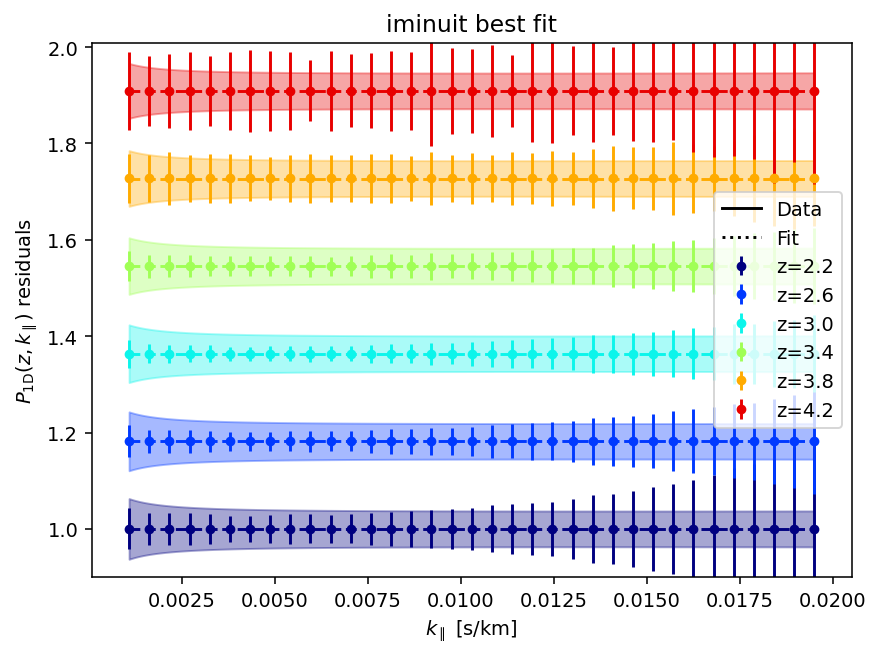

In [20]:
minimizer.plot_best_fit(plot_every_iz=2)

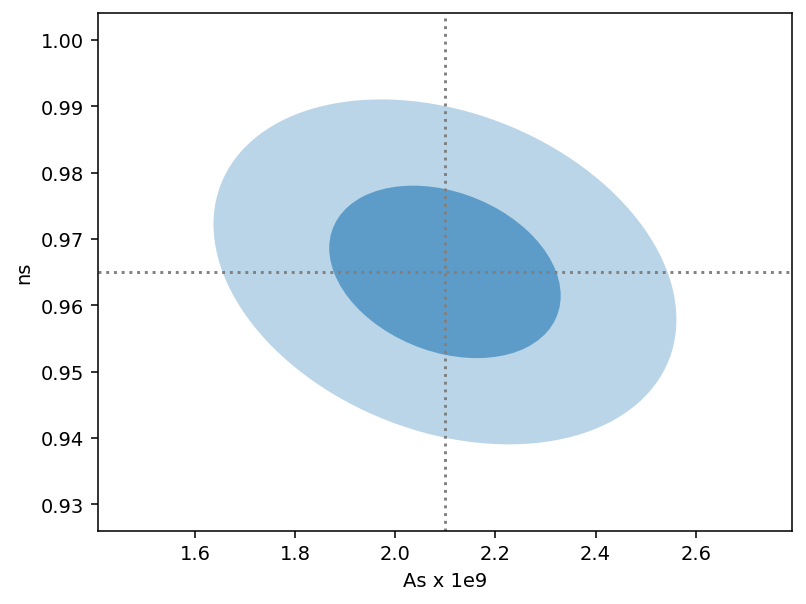

In [21]:
minimizer.plot_ellipses("As", "ns")

In [31]:
# minimizer.plot_ellipses("ln_gamma_0", "ln_sigT_kms_0")

In [ ]:
# minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [22]:
r

NameError: name 'r' is not defined

In [23]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 153.5                      │             Nfcn = 1301              │
│ EDM = 1.25e-08 (Goal: 0.0001)    │            time = 7.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.40    │   0.07    │            │            │         │         │       │
│ 1 │ x1   │   0.445   │   0.020   │            │            │         │         │       │
│ 2 │ x2   │   0.50    │   0.08    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.13    │            │            │         │         │       │
│ 5 │ x5   │   0.50    │   0.07    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.07    │            │            │         │         │       │
│ 7 │ x7   │   0.50    │   0.08    │            │            │         │         │       │
│ 8 │ x8   │   0.50    │   0.21    │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7       x8       x9 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  0.00473  -0.4e-3   -0.004  -0.0006   -0.004    0.004    0.000    0.002   -0.003   -0.001 │
│ x1 │  -0.4e-3 0.000413  -0.1e-3   0.2e-3  -0.2e-3  -0.9e-3   0.2e-3  -0.6e-3   0.2e-3  -0.5e-3 │
│ x2 │   -0.004  -0.1e-3  0.00694  -0.0018    0.010   -0.002   -0.001   -0.000    0.003   -0.001 │
│ x3 │  -0.0006   0.2e-3  -0.0018  0.00136  -0.0031  -0.0008   0.0001  -0.0007   0.0002   0.0013 │
│ x4 │   -0.004  -0.2e-3    0.010  -0.0031   0.0165   -0.002   -0.002    0.002    0.003   -0.003 │
│ x5 │    0.004  -0.9e-3   -0.002  -0.0008   -0.002  0.00474   -0.001    0.003   -0.006    0.000 │
│ x6 │    0.000   0.2e-3   -0.001   0.0001   -0.002   -0.001  0.00527   -0.005    0.012    0.001 │
│ x7 │    0.002  -0.6e-3   -0.000  -0.0007    0.002    0.003   -0.005  0.00606   -0.010   -0.001 │
│ x8 │   -0.003   0.2e-3    0.003   0.0002    0.003   -0.006    0.012   -0.010   0.0437    0.003 │
│ x9 │   -0.001  -0.5e-3   -0.001   0.0013   -0.003    0.000    0.001   -0.001    0.003  0.00384 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [29]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(8.547653724544357e-07, 0.0016794913300527611)

In [30]:
minimizer.best_fit_value('ns',return_hesse=True)

(0.9649998966346979, 0.00164617720440885)

## Plot results all

In [41]:
from matplotlib.patches import Ellipse

In [42]:
# data_label = "QMLE_Ohio"
data_label = "Chabanier2019"

folder_figs = (
    path_program + "data/cup1d/likelihood/max_like_mock/" + data_label + "_"
)

# emulator_label = ["mpg_gp_hr", "mpg_gp_lr", "mpg_nn_lr", "nyx_nn_lr"]
emulator_label = [
    "mpg_gp_lr",
    "mpg_gp_hr",
    "mpg_nn_lr",
    "mpg_nn_hr",
    "nyx_nn_lr",
]

dat = []
for lab in emulator_label:
    dat.append(np.load(folder_figs + lab + ".npz"))

In [43]:
dat[0].files

['arr_parx', 'arr_pary', 'arr_sig_x', 'arr_sig_y', 'arr_r']

In [44]:
r

0.24967645818717718


-0.7853981633974484 -0.270437336538242
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

0.7853981633974484 0.5968959993489935
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

0.7853981633974484 0.7872088421265341
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

-0.7853981633974484 -0.7588236227982372
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

0.7853981633974484 0.3373842933578331
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


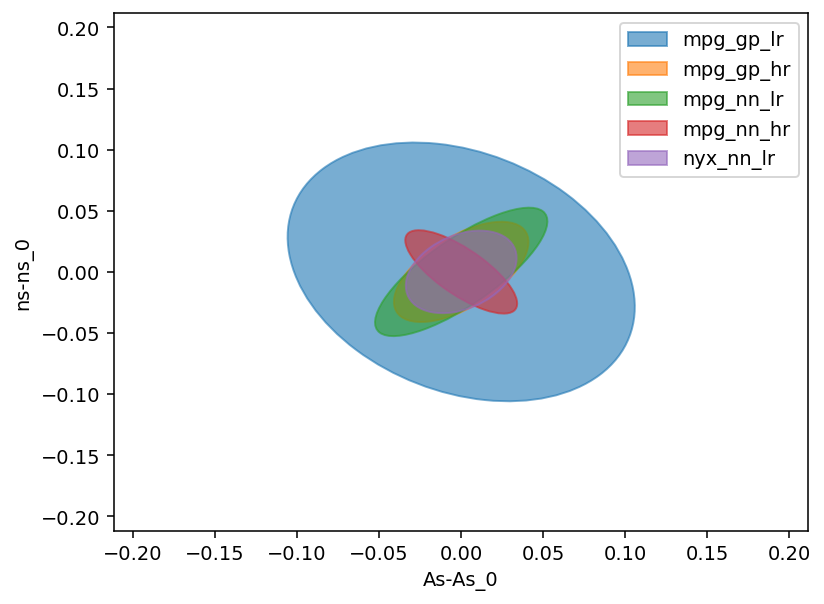

In [64]:
sig_xm = 0
sig_ym = 0

for jj, lab in enumerate(emulator_label):

    ii = 0
    nsig = 1
    pname_x = dat[jj]["arr_parx"][ii]
    pname_y = dat[jj]["arr_pary"][ii]
    sig_x = dat[jj]["arr_sig_x"][ii]
    if sig_x > sig_xm:
        sig_xm = sig_x * 1
    sig_y = dat[jj]["arr_sig_x"][ii]
    if sig_y > sig_ym:
        sig_ym = sig_y * 1
    r = dat[jj]["arr_r"][ii]
    val_x = 0
    val_y = 0

    w, v = np.linalg.eig(
        np.array(
            [[sig_x**2, sig_x * sig_y * r], [sig_x * sig_y * r, sig_y**2]]
        )
    )

    # semi-major and semi-minor axis of ellipse
    a = np.sqrt(w[0])
    b = np.sqrt(w[1])

    # figure out inclination angle of ellipse
    alpha = np.arccos(v[0, 0])
    if v[1, 0] < 0:
        alpha = -alpha
    # compute angle in degrees (expected by matplotlib)
    alpha_deg = alpha * 180 / np.pi
    print("")
    print(alpha, r)
    print(v)

    # make plot
    fig = plt.subplot(111)
    for isig in range(1, nsig + 1):
        if isig == 1:
            lab0 = lab
        else:
            lab0 = None
        ell = Ellipse(
            (val_x, val_y),
            2 * isig * a,
            2 * isig * b,
            alpha_deg,
            label=lab0,
            color="C" + str(jj),
        )
        ell.set_alpha(0.6 / isig)
        fig.add_artist(ell)

plt.legend()
plt.xlabel(pname_x + "-" + pname_x + "_0")
plt.ylabel(pname_y + "-" + pname_y + "_0")
plt.xlim(val_x - (nsig + 1) * sig_xm, val_x + (nsig + 1) * sig_xm)
plt.ylim(val_y - (nsig + 1) * sig_ym, val_y + (nsig + 1) * sig_ym)
plt.savefig(folder_figs + "As_ns.png")

In [74]:
import matplotlib.transforms as transforms

(-0.21169622010114364, 0.21169622010114364)

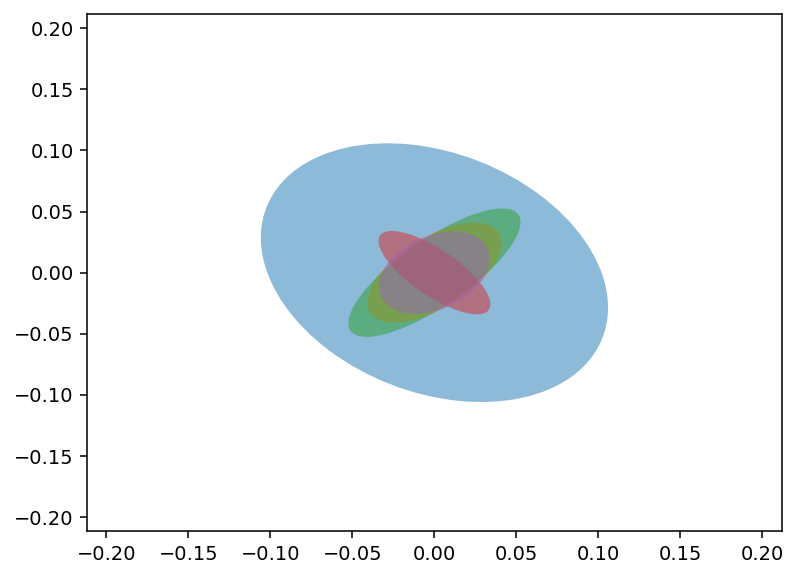

In [92]:
fig, ax = plt.subplots(1, 1)

for jj, lab in enumerate(emulator_label):

    ii = 0
    nsig = 1
    pname_x = dat[jj]["arr_parx"][ii]
    pname_y = dat[jj]["arr_pary"][ii]
    sig_x = dat[jj]["arr_sig_x"][ii]
    if sig_x > sig_xm:
        sig_xm = sig_x * 1
    sig_y = dat[jj]["arr_sig_x"][ii]
    if sig_y > sig_ym:
        sig_ym = sig_y * 1
    r = dat[jj]["arr_r"][ii]
    val_x = 0
    val_y = 0

    cov = np.array(
        [[sig_x**2, sig_x * sig_y * r], [sig_x * sig_y * r, sig_y**2]]
    )
    confidence_ellipse(cov, ax, facecolor='C'+str(jj))

plt.xlim(-2*sig_xm, 2*sig_xm)
plt.ylim(-2*sig_ym, 2*sig_ym)

In [91]:
def confidence_ellipse(cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
#     if x.size != y.size:
#         raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, alpha=0.5, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = 0

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = 0

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

#### Understand degeneracies!!